In [1]:
using LinearAlgebra, Plots

In [106]:
function vectorised_Bellman_VFI_howard(P, tolerance, max_iterations, grid_size, m)

    grid = LinRange(0.1,1000,grid_size)

    grid = reshape(grid, (grid_size,1))

    v = zeros(grid_size,1)

    policy = zeros(grid_size,1)

    iter = 0

    if iter == 0
        println("Iterating...")
    end

    error = tolerance + 1

    consumption = P[5] .* grid .^ P[1] + (1-P[4]) .* grid .- transpose(grid)

    while ((tolerance < error) && (iter < max_iterations))

        c_positive = consumption .> 0

        consumption_positive = consumption .* c_positive

        v_new = log.(consumption_positive) .+ (P[2] .* transpose(v))

        v_new[.!c_positive] .= -Inf

        vmax, vmax_indices = findmax(v_new, dims=2)
        
        index = getindex.(vmax_indices, [1 2])

        policy = grid[index[:,2]]

        c_howard = P[5] .* grid .^ P[1] + (1-P[4]) .* grid .- policy

        for _ in 1:m

            v_howard = log.(c_howard) .+ (P[2] .* vmax)

            vmax .= v_howard
        
        end

        error = maximum(vmax .- v)

        v .= vmax

        if isinteger(iter/25) == true
            println("iteration $iter completed with error $error")
        end
        
        iter += 1

    end

    println("converged in $iter iterations")

    display(Plots.plot(grid, v, title="Value Function", label="Value"))
    
    display(Plots.plot(grid, policy, title="Policy Function", label="Policy"))

    return v, policy

end

vectorised_Bellman_VFI_howard (generic function with 1 method)

In [3]:
Params = [0.33, 0.9, 0.0, 0.1, 2.0]

v_out_old, pol_out_old = vectorised_Bellman_VFI_howard(Params, 1e-6, 1000, 101, 100)

UndefVarError: UndefVarError: `vectorised_Bellman_VFI_howard` not defined

In [2]:
pars = (;α = 0.33, # Capital Share
        β = 0.90, # Discount Factor
        γ = 1.0, # CRRA Parameter
        δ = 0.1, # Depreciation Rate
        A = 2.0, # TFP
        grid_size = 101, # Capital Grid Size
        grid_min = 0.75, # Minimum Capital (multiple of steady state)
        grid_max = 1.25, # Maximum Capital (multiple of steady state)
        maxiter =10000, # Max Iterations
        toler = 1e-6, # Tolerance
        m = 1) # Howard Iterations

(α = 0.33, β = 0.9, γ = 1.0, δ = 0.1, A = 2.0, grid_size = 101, grid_min = 0.75, grid_max = 1.25, maxiter = 10000, toler = 1.0e-6, m = 1)

In [7]:
function utility(c, pars)
    if pars.γ == 1
        return log(c)
    else
        return (c^(1-pars.γ))/(1-pars.γ)
    end
end

function utility_vec(c, pars)
    if pars.γ == 1
        return log.(c)
    else
        return (c.^(1-pars.γ))./(1-pars.γ)
    end
end

utility_vec (generic function with 1 method)

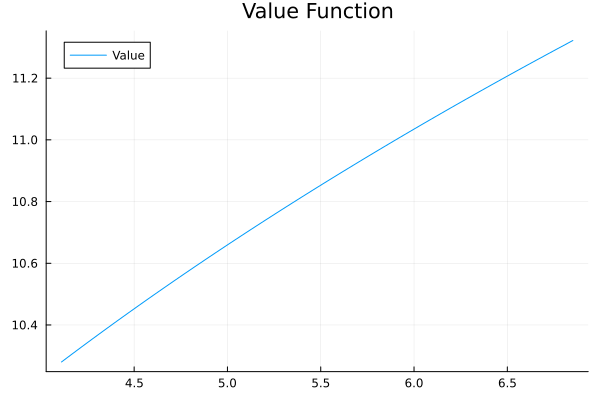

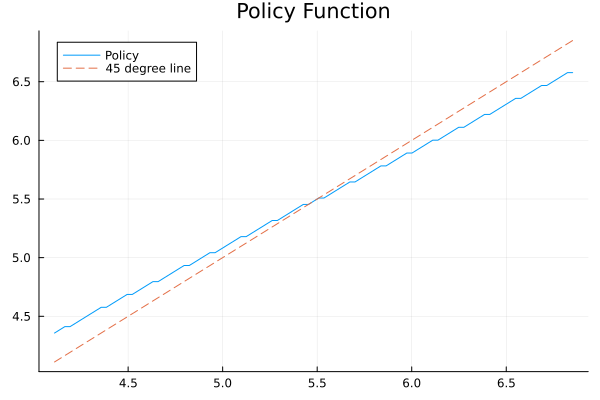

Iterating...
--------------------
iteration 0 completed with error 1.762951428590337
--------------------
converged in 133 iterations
--------------------
  1.705820 seconds (1.59 M allocations: 111.643 MiB, 1.01% gc time, 90.28% compilation time: 1% of which was recompilation)


([10.280086441180593; 10.292588598573836; … ; 11.313157765069386; 11.322013762004904;;], [4.357346730341667; 4.38475142675891; … ; 6.577127140138365; 6.577127140138365;;])

In [8]:
function vfi_nt_brute_force(v, pars)
    (; α, β, γ, δ, A, grid_size, grid_min, grid_max, maxiter, toler) = pars
    v_new = similar(v)
    policy = similar(v)
    Kss = ((A*α*β)/(1-β*(1-δ)))^(1/(1-α))
    kgrid = LinRange(grid_min*Kss,grid_max*Kss,grid_size)
    dist = zeros(grid_size,1)
    iter = 0
    error = toler + 1
    if iter == 0
        println("Iterating...")
    end
    while ((error > toler) && (iter < maxiter))
        for i in 1:grid_size
            vmax = -Inf
            for j in 1:grid_size
                consump = A*kgrid[i]^α + (1-δ)*kgrid[i] - kgrid[j]
                if consump >= 0
                    v_temp = utility(consump, pars) + β*v[j]
                    if v_temp > vmax
                        vmax = v_temp
                        policy[i] = kgrid[j]
                    end
                end
            end
            v_new[i] = vmax
            dist[i] = v_new[i] - v[i]
        end
        error = maximum(dist)
        if isinteger(iter/250) == true
            println("--------------------")
            println("iteration $iter completed with error $error")
        end
        iter += 1
        v = copy(v_new)
    end
    println("--------------------")
    println("converged in $iter iterations")
    println("--------------------")
    display(Plots.plot(kgrid, v, title="Value Function", label="Value")) 
    pol_plot = Plots.plot(kgrid, policy, title="Policy Function", label="Policy")
    Plots.plot!(kgrid, kgrid, label="45 degree line", linestyle=:dash)
    display(pol_plot)
    return v, policy
end

@time begin
    v_out_nt, pol_out_nt = vfi_nt_brute_force(zeros(pars.grid_size,1), pars)
end

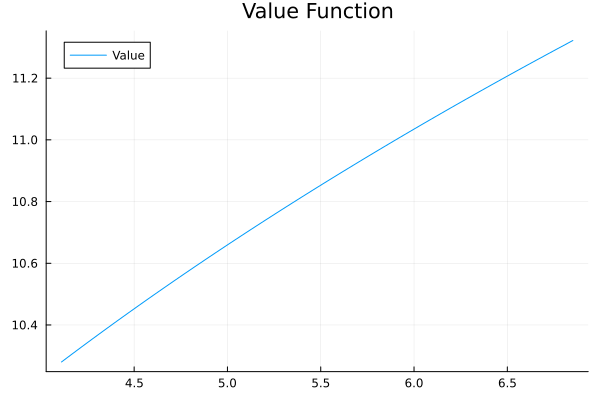

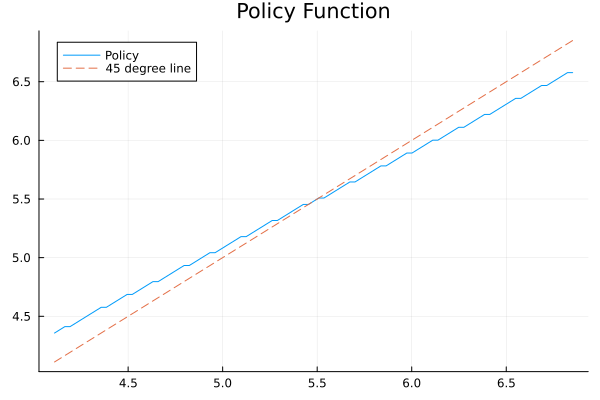

Iterating...
--------------------
iteration 0 completed with error 1.762951428590337
--------------------
converged in 133 iterations
--------------------
  1.604032 seconds (2.09 M allocations: 157.127 MiB, 2.29% gc time, 93.28% compilation time)


([10.280086441180593; 10.292588598573836; … ; 11.313157765069384; 11.322013762004902;;], [4.357346730341667, 4.38475142675891, 4.412156123176153, 4.412156123176153, 4.439560819593396, 4.46696551601064, 4.494370212427882, 4.521774908845126, 4.549179605262369, 4.5765843016796115  …  6.385294265217663, 6.412698961634906, 6.4401036580521485, 6.467508354469392, 6.467508354469392, 6.494913050886636, 6.5223177473038785, 6.549722443721121, 6.577127140138365, 6.577127140138365])

In [9]:
function vfi_nt_vectorised(v, pars)
    (; α, β, γ, δ, A, grid_size, grid_min, grid_max, maxiter, toler) = pars
    v_new = zeros(grid_size,grid_size)
    policy = similar(v)
    Kss = ((A*α*β)/(1-β*(1-δ)))^(1/(1-α))
    kgrid = LinRange(grid_min*Kss,grid_max*Kss,grid_size)
    iter = 0
    error = toler + 1
    if iter == 0
        println("Iterating...")
    end
    cons = A.*kgrid.^α .+ (1-δ).*kgrid .- transpose(kgrid)
    c_pos = cons .> 0
    pos_c = cons .* c_pos
    while ((error > toler) && (iter < maxiter))
        v_new = utility_vec(pos_c, pars) .+ β.*transpose(v)
        v_new[.!c_pos] .= -Inf
        vmax, vmax_indices = findmax(v_new, dims=2)
        index = getindex.(vmax_indices, [1 2])
        policy = kgrid[index[:,2]] 
        error = maximum(vmax .- v)
        v .= vmax
        if isinteger(iter/250) == true
            println("--------------------")
            println("iteration $iter completed with error $error")
        end
        iter += 1
    end
    println("--------------------")
    println("converged in $iter iterations")
    println("--------------------")
    display(Plots.plot(kgrid, v, title="Value Function", label="Value")) 
    pol_plot = Plots.plot(kgrid, policy, title="Policy Function", label="Policy")
    Plots.plot!(kgrid, kgrid, label="45 degree line", linestyle=:dash)
    display(pol_plot)
    return v, policy
end

@time begin
    v_out_nt_vec, pol_out_nt_vec = vfi_nt_vectorised(zeros(pars.grid_size,1), pars)
end 

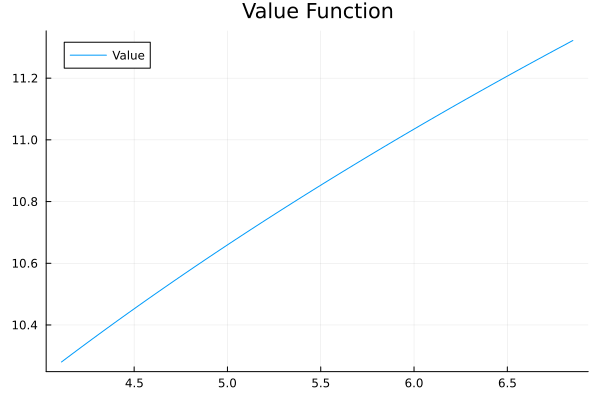

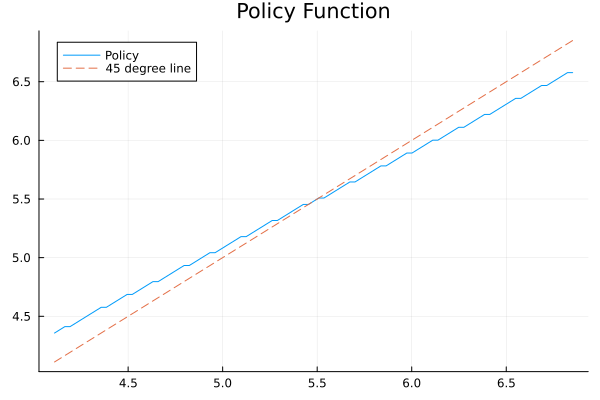

Iterating...
--------------------
iteration 0 completed with error 6.671974964734428
--------------------
converged in 56 iterations
--------------------
  0.511132 seconds (245.90 k allocations: 16.185 MiB, 72.43% compilation time)


([10.280095409419676; 10.292597566812919; … ; 11.313165793646853; 11.322021790582372;;], [4.357346730341667; 4.38475142675891; … ; 6.577127140138365; 6.577127140138365;;])

In [10]:
function mqp_nt_brute_force(v, pars)
    (; α, β, γ, δ, A, grid_size, grid_min, grid_max, maxiter, toler) = pars
    v_new = similar(v)
    policy = similar(v)
    Kss = ((A*α*β)/(1-β*(1-δ)))^(1/(1-α))
    kgrid = LinRange(grid_min*Kss,grid_max*Kss,grid_size)
    dist = zeros(grid_size,1)
    iter = 0
    error = toler + 1
    if iter == 0
        println("Iterating...")
    end
    while ((error > toler) && (iter < maxiter))
        for i in 1:grid_size
            vmax = -Inf
            for j in 1:grid_size
                consump = A*kgrid[i]^α + (1-δ)*kgrid[i] - kgrid[j]
                if consump >= 0
                    v_temp = utility(consump, pars) + β*v[j]
                    if v_temp > vmax
                        vmax = v_temp
                        policy[i] = kgrid[j]
                    end
                end
            end
            v_new[i] = vmax
            dist[i] = v_new[i] - v[i]
        end
        low_bound = minimum(v_new .- v) .* (β / (1 - β))
        high_bound = maximum(v_new .- v) .* (β / (1 - β))
        error = high_bound - low_bound
        if isinteger(iter/250) == true
            println("--------------------")
            println("iteration $iter completed with error $error")
        end
        iter += 1
        v = copy(v_new) .+ (low_bound + high_bound)/2
    end
    println("--------------------")
    println("converged in $iter iterations")
    println("--------------------")
    display(Plots.plot(kgrid, v, title="Value Function", label="Value")) 
    pol_plot = Plots.plot(kgrid, policy, title="Policy Function", label="Policy")
    Plots.plot!(kgrid, kgrid, label="45 degree line", linestyle=:dash)
    display(pol_plot)
    return v, policy
end

@time begin
    v_mqp_nt, pol_mqp_nt = mqp_nt_brute_force(zeros(pars.grid_size,1), pars)
end 

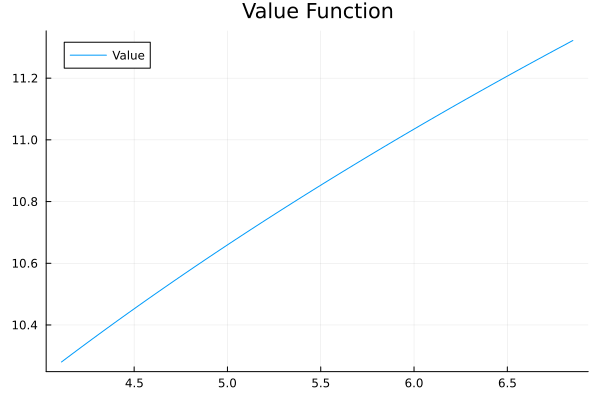

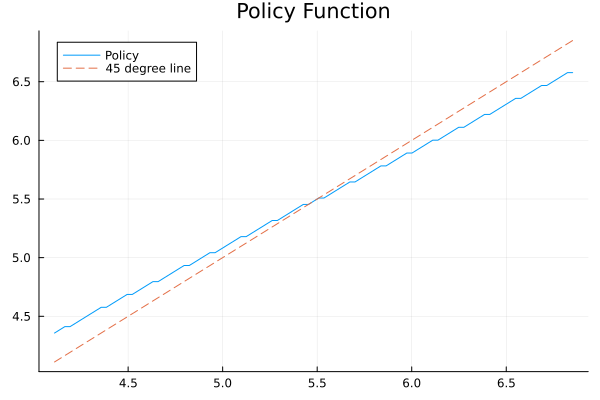

Iterating...
--------------------
iteration 0 completed with error 6.671974964734428
--------------------
converged in 56 iterations
--------------------
  0.895129 seconds (431.62 k allocations: 34.798 MiB, 90.55% compilation time)


([10.280095409419665; 10.292597566812912; … ; 11.313165793646846; 11.322021790582363;;], [4.357346730341667, 4.38475142675891, 4.412156123176153, 4.412156123176153, 4.439560819593396, 4.46696551601064, 4.494370212427882, 4.521774908845126, 4.549179605262369, 4.5765843016796115  …  6.385294265217663, 6.412698961634906, 6.4401036580521485, 6.467508354469392, 6.467508354469392, 6.494913050886636, 6.5223177473038785, 6.549722443721121, 6.577127140138365, 6.577127140138365])

In [11]:
function mqp_nt_vectorised(v, pars)
    (; α, β, γ, δ, A, grid_size, grid_min, grid_max, maxiter, toler) = pars
    v_new = zeros(grid_size,grid_size)
    policy = similar(v)
    Kss = ((A*α*β)/(1-β*(1-δ)))^(1/(1-α))
    kgrid = LinRange(grid_min*Kss,grid_max*Kss,grid_size)
    iter = 0
    error = toler + 1
    if iter == 0
        println("Iterating...")
    end
    cons = A.*kgrid.^α .+ (1-δ).*kgrid .- transpose(kgrid)
    c_pos = cons .> 0
    pos_c = cons .* c_pos
    while ((error > toler) && (iter < maxiter))
        v_new = utility_vec(pos_c, pars) .+ β.*transpose(v)
        v_new[.!c_pos] .= -Inf
        vmax, vmax_indices = findmax(v_new, dims=2)
        index = getindex.(vmax_indices, [1 2])
        policy = kgrid[index[:,2]] 
        high_bound = maximum(vmax .- v) .* (β / (1 - β))
        low_bound = minimum(vmax .- v) .* (β / (1 - β))
        error = high_bound - low_bound
        if isinteger(iter/250) == true
            println("--------------------")
            println("iteration $iter completed with error $error")
        end
        v .= vmax .+ (low_bound + high_bound)/2
        iter += 1
    end
    println("--------------------")
    println("converged in $iter iterations")
    println("--------------------")
    display(Plots.plot(kgrid, v, title="Value Function", label="Value")) 
    pol_plot = Plots.plot(kgrid, policy, title="Policy Function", label="Policy")
    Plots.plot!(kgrid, kgrid, label="45 degree line", linestyle=:dash)
    display(pol_plot)
    return v, policy
end

@time begin
    v_mqp_nt_vec, pol_mqp_nt_vec = mqp_nt_vectorised(zeros(pars.grid_size,1), pars)
end 

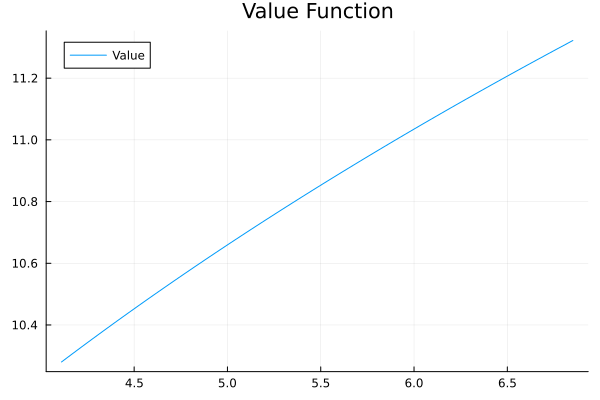

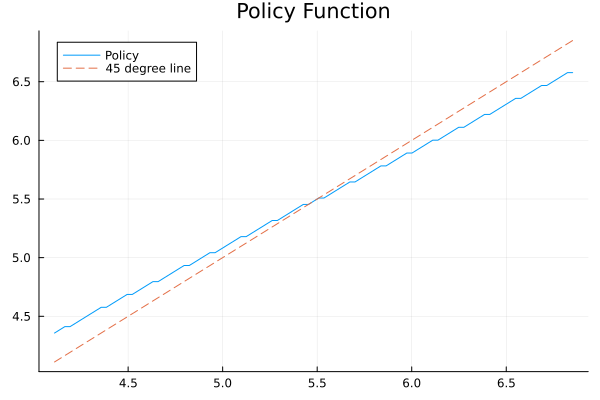

Iterating...
--------------------
iteration 0 completed with error 2.682410217848197
--------------------
converged in 70 iterations
--------------------
  0.453740 seconds (147.52 k allocations: 9.649 MiB, 1.59% gc time, 76.27% compilation time)


([10.280090866955488; 10.292593024348731; … ; 11.313162190961549; 11.322018187897067;;], [4.357346730341667; 4.38475142675891; … ; 6.577127140138365; 6.577127140138365;;])

In [12]:
function howard_nt_brute_force(v, pars)
    (; α, β, γ, δ, A, grid_size, grid_min, grid_max, maxiter, toler, m) = pars
    v_new = similar(v)
    v2 = similar(v)
    policy = similar(v)
    idx = zeros(Int, grid_size,1)
    Kss = ((A*α*β)/(1-β*(1-δ)))^(1/(1-α))
    kgrid = LinRange(grid_min*Kss,grid_max*Kss,grid_size)
    dist = zeros(grid_size,1)
    iter = 0
    error = toler + 1
    if iter == 0
        println("Iterating...")
    end
    while ((error > toler) && (iter < maxiter))
        for i in 1:grid_size
            vmax = -Inf
            for j in 1:grid_size
                consump = A*kgrid[i]^α + (1-δ)*kgrid[i] - kgrid[j]
                if consump >= 0
                    v_temp = utility(consump, pars) + β*v[j]
                    if v_temp > vmax
                        vmax = v_temp
                        policy[i] = kgrid[j]
                        idx[i] = j
                    end
                end
            end
            v_new[i] = vmax
        end
        for _ in 1:m
            for i in 1:grid_size
                j = idx[i]
                c = A*kgrid[i]^α + (1-δ) * kgrid[i] - policy[i]
                v2[i] = utility(c, pars) + β * v_new[j]
            end  
            v_new .= copy(v2)    
        end
        error = maximum(v_new .- v)
        if isinteger(iter/250) == true
            println("--------------------")
            println("iteration $iter completed with error $error")
        end
        iter += 1
        v = copy(v_new)
    end
    println("--------------------")
    println("converged in $iter iterations")
    println("--------------------")
    display(Plots.plot(kgrid, v, title="Value Function", label="Value")) 
    pol_plot = Plots.plot(kgrid, policy, title="Policy Function", label="Policy")
    Plots.plot!(kgrid, kgrid, label="45 degree line", linestyle=:dash)
    display(pol_plot)
    return v, policy
end

@time begin
    v_howard_nt, pol_howard_nt = howard_nt_brute_force(zeros(pars.grid_size,1), pars)
end

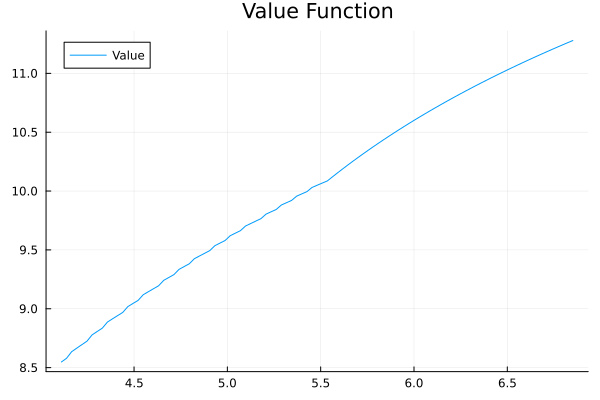

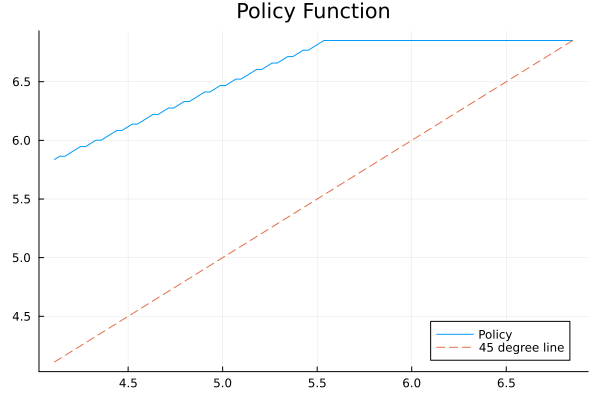

([8.548027154803805; 8.578981476946169; … ; 11.260623622201043; 11.27894995405486;;], [5.837200336872798, 5.864605033290042, 5.864605033290042, 5.8920097297072855, 5.919414426124528, 5.946819122541771, 5.946819122541771, 5.974223818959015, 6.001628515376257, 6.001628515376257  …  6.851174104310797, 6.851174104310797, 6.851174104310797, 6.851174104310797, 6.851174104310797, 6.851174104310797, 6.851174104310797, 6.851174104310797, 6.851174104310797, 6.851174104310797])

In [36]:
function howard_nt_vectorised(v, pars)
    (; α, β, γ, δ, A, grid_min, grid_max, grid_size, maxiter, toler, m) = pars
    v_new = zeros(grid_size,grid_size)
    policy = similar(v)
    vmax = similar(v)
    v_howard = similar(v)
    c_howard = similar(v)
    Kss = ((A*α*β)/(1-β*(1-δ)))^(1/(1-α))
    kgrid = LinRange(grid_min*Kss,grid_max*Kss,grid_size)
    kgrid = reshape(kgrid, (grid_size,1))
    iter = 0
    error = toler + 1
    if iter == 0
        println("Iterating...")
    end
    cons = A.*kgrid.^α .+ (1-δ).*kgrid .- transpose(kgrid)
    c_pos = cons .> 0
    util = similar(cons)
    util_howard = similar(v)
    util[.!c_pos] .= -Inf
    util[c_pos] = utility_vec(cons[c_pos], pars)
    while ((error > toler) && (iter < maxiter))
        v_new = util .+ β.*transpose(v)
        vmax, vmax_indices = findmax(v_new, dims=2)
        index = getindex.(vmax_indices, [1 2])
        policy = kgrid[index[:,2]]
        for _ in 1:m
            new_c = A .* kgrid.^α .+ (1-δ) .* kgrid .- policy
            c_pos_howard = new_c .> 0
            util_howard[.!c_pos_howard] .= -Inf
            util_howard[c_pos_howard] = utility_vec(new_c[c_pos_howard], pars)
            v_howard = util_howard .+ β .* vmax
            vmax .= v_howard
        end
        error = maximum(vmax .- v)
        v .= vmax
        if isinteger(iter/250) == true
            println("--------------------")
            println("iteration $iter completed with error $error")
        end
        iter += 1
    end
    println("--------------------")
    println("converged in $iter iterations")
    println("--------------------")
    display(Plots.plot(kgrid, v, title="Value Function", label="Value")) 
    pol_plot = Plots.plot(kgrid, policy, title="Policy Function", label="Policy")
    Plots.plot!(kgrid, kgrid, label="45 degree line", linestyle=:dash)
    display(pol_plot)
    return v, policy
end

@time begin
    v_howard_nt_vec, pol_howard_nt_vec = howard_nt_vectorised(zeros(pars.grid_size,1), pars)
end